In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib


In [2]:
train_path = 'C:/Users/user/Desktop/Bitirme/216-data/Train'


In [3]:
bins = 8


In [4]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [5]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [6]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [7]:
train_labels = os.listdir(train_path)


In [8]:
# sort the training labels
train_labels.sort()
print(train_labels)


['Benign', 'Insitu', 'Invasive', 'Normal']


In [9]:
# empty lists to hold feature vectors and labels
global_features = []
labels = []
fixed_size = tuple((500, 500))

i, j = 0, 0
k = 0

In [10]:
for training_name in train_labels:
    # join the training data path and each species training folder
    path = glob.glob("C:/Users/user/Desktop/Bitirme/216-data/Train/"+training_name+"/*.tif")

    
    # get the current training label
    current_label = training_name
    
    k = 1
    x=0
    # loop over the images in each sub-folder
    for file in path:
        if x<15000:
             # read the image 
            image = cv2.imread(file)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
            labels.append(current_label)
            global_features.append(global_feature)

            i += 1
            k += 1 
            x=x+1
    print ("[STATUS] processed folder: {}".format(current_label))
    j += 1

[STATUS] processed folder: Benign
[STATUS] processed folder: Insitu
[STATUS] processed folder: Invasive
[STATUS] processed folder: Normal


In [11]:
print ("[STATUS] completed Global Feature Extraction...")

# get the overall feature vector siz
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))

print ("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (15161, 532)
[STATUS] training Labels (15161,)


In [12]:
# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [13]:
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print( "[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (15161,)


In [14]:
# save the feature vector using HDF5
h5f_data = h5py.File('output/data_256.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels_256.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In [15]:
# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=10, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))

In [16]:
# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

In [17]:
# import the feature vector and trained labels
h5f_data = h5py.File('output/data_256.h5', 'r')
h5f_label = h5py.File('output/labels_256.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [18]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=0.2,
                                                                                          random_state=9)

In [19]:
print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print( "Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (12128, 532)
Test data   : (3033, 532)
Train labels: (12128,)
Test labels : (3033,)


In [20]:
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
# k-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.645695 (0.005908)
LDA: 0.677276 (0.006074)
KNN: 0.818767 (0.004873)
DTC: 0.726252 (0.009148)
RF: 0.807471 (0.006533)
NB: 0.310850 (0.008270)
SVM: 0.663918 (0.008942)


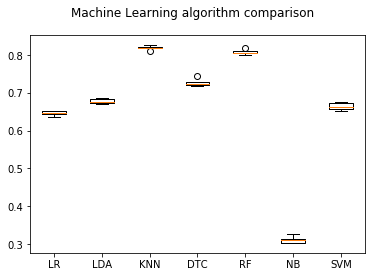

In [22]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [23]:
from sklearn import metrics
for name, model in models:
    clf=model
    clf.fit(trainDataGlobal, trainLabelsGlobal)
    y_pred=clf.predict(testDataGlobal)
    msg = "%s: %f " % (name, metrics.accuracy_score(y_pred,testLabelsGlobal))
    print(msg)

LR: 0.662380 
LDA: 0.689746 
KNN: 0.835806 
DTC: 0.731619 
RF: 0.821299 
NB: 0.332344 
SVM: 0.679855 
